# Scoring Segmentation

Segment an image with corresponding ground truth and score different network performances

In [165]:
import napari
import cellpose
import octopuslite
from octopuslite import tile
from tqdm.auto import tqdm
import numpy as np
import datetime 
from skimage.io import imsave, imshow, imread
from skimage.measure import label, regionprops
import skimage as ski
from skimage.morphology import remove_small_objects, remove_small_holes, binary_erosion
import os
import itertools, os
from tqdm.auto import tqdm
import scipy.ndimage as ndi
import sys
sys.path.append('../../unet_segmentation_metrics/')
import umetrics
import matplotlib.pyplot as plt

!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Wed Jan 11 17:28:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   45C    P8    35W / 300W |  48641MiB / 49140MiB |     28%      Default |
|                               |                      |                  N/A |
+

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = octopuslite.utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout_df = octopuslite.utils.read_harmony_metadata(metadata_path, assay_layout=True)
octopuslite.utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Load ground truth-image pairs

And tidy up image so that it is in binary format

In [174]:
gt = imread('/mnt/DATA/macrohet/segmentation/training/ground_truth/r03c04f*p01-ch99sk38fk1fl1.tiff_2023_01_10-05:48:17_pm.tiff')#.astype(np.uint16)
img = imread('/mnt/DATA/macrohet/segmentation/training/ground_truth/r03c04f*p01-ch1sk38fk1fl1.tiff')#.astype(np.uint16)

In [175]:
true = gt
### unique labels
true = label(true)
true = remove_small_objects(true, min_size=10000)
### need to iterate over each individual segment and erode
new_mask = np.zeros(true.shape, dtype = np.uint8)
for segment_ID in tqdm(range(1, np.max(true))):
    segment = true == segment_ID 
    eroded_segment = binary_erosion(segment)
    new_mask += eroded_segment.astype(np.uint8)
true = remove_small_holes(new_mask).astype(np.uint8)

  0%|          | 0/1072 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


#### Tidy up ground truth by removing small objects, closing holes and creating unique labels

# Conduct quick segementation param search on this example img 

how many params can i realistically get awqay with searching over tonight

In [134]:
### average cell diameter
diameters = np.linspace(150, 300, 10)#[150, 200, 250, 300, ]
### flow threshold, larger value means more ROIs (maybe ill fitting), lower means fewer ROIs 
flow_thresholds = np.linspace(0,2, 16)#[0.1, 0.2, 0.3, 0.5, 1, 1.2, 1.5]
### cellprob_threshold, larger is is fewer ROIs, lower means more...? 
cellprobs_thresholds = np.linspace(-6,6, 16)#[-0.2, 0.0, 0.2]

In [135]:
params = list(itertools.product(diameters, flow_thresholds, cellprobs_thresholds))
len(params)

2560

In [136]:
model_output_dict_coarse = dict()

In [157]:
for diameter, flow_threshold, cellprob_threshold in tqdm(params, total = len(params)):
    
    mask_stack = []
    masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=[0,0],
                                             flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)        
    model_output_dict[(diameter, flow_threshold, cellprob_threshold)] = masks
    np.save('model_output_dict.npy', model_output_dict)

  0%|          | 0/2560 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Stopping here to conduct a IoU analysis on masks already generated

In [159]:
len(model_output_dict)

697

# Prepare model output for scoring

Binarise and remove holes etc

note: this will take too long and I want to check results tomorrow morning. So will compute for every 40 items...

In [179]:
n = 41

In [184]:
np.linspace(0,697, 18, dtype=int)

array([  0,  41,  82, 123, 164, 205, 246, 287, 328, 369, 410, 451, 492,
       533, 574, 615, 656, 697])

In [ ]:
for n, param in tqdm(enumerate(model_output_dict), 
                     total = len(np.linspace(0,697, 18, dtype=int))):
    
    
    if n in np.linspace(0,697, 18, dtype=int):
        
    
    
        pred = model_output_dict[param]
        pred = remove_small_objects(pred, min_size=10000)
        ### need to iterate over each individual segment and erode
        new_mask = np.zeros(pred.shape, dtype = np.uint8)
        for segment_ID in tqdm(range(1, np.max(pred))):
            segment = pred == segment_ID 
            eroded_segment = binary_erosion(segment)
            new_mask += eroded_segment.astype(np.uint8)
        pred = remove_small_holes(new_mask).astype(np.uint8)
        model_output_dict[param] = pred


In [187]:
np.save('model_output_dict_cleaned.npy', model_output_dict)

# Conduct segmentation scoring 

In [193]:
for i in model_output_dict:
    print(i)

(150.0, 0.0, -6.0)
(150.0, 0.0, -5.2)
(150.0, 0.0, -4.4)
(150.0, 0.0, -3.5999999999999996)
(150.0, 0.0, -2.8)
(150.0, 0.0, -2.0)
(150.0, 0.0, -1.1999999999999993)
(150.0, 0.0, -0.39999999999999947)
(150.0, 0.0, 0.40000000000000036)
(150.0, 0.0, 1.2000000000000002)
(150.0, 0.0, 1.2000000000000002)
(150.0, 0.0, 2.0)
(150.0, 0.0, 2.8000000000000007)
(150.0, 0.0, 3.6000000000000014)
(150.0, 0.0, 4.4)
(150.0, 0.0, 5.200000000000001)
(150.0, 0.0, 6.0)
(150.0, 0.13333333333333333, -6.0)
(150.0, 0.13333333333333333, -5.2)
(150.0, 0.13333333333333333, -4.4)
(150.0, 0.13333333333333333, -3.5999999999999996)
(150.0, 0.13333333333333333, -2.8)
(150.0, 0.13333333333333333, -2.0)
(150.0, 0.13333333333333333, -1.1999999999999993)
(150.0, 0.13333333333333333, -0.39999999999999947)
(150.0, 0.13333333333333333, 0.40000000000000036)
(150.0, 0.13333333333333333, 1.2000000000000002)
(150.0, 0.13333333333333333, 2.0)
(150.0, 0.13333333333333333, 2.8000000000000007)
(150.0, 0.13333333333333333, 3.60000000000

In [191]:
for n, param in tqdm(enumerate(model_output_dict), 
                     total = len(np.linspace(0,697, 18, dtype=int))):
    
    
    if n in np.linspace(0,697, 18, dtype=int):
        print(param)

  0%|          | 0/18 [00:00<?, ?it/s]

(150.0, 0.0, -6.0)
(150.0, 0.26666666666666666, 0.40000000000000036)
(150.0, 0.6666666666666666, -5.2)
(150.0, 0.9333333333333333, 2.0)
(150.0, 1.3333333333333333, -3.5999999999999996)
(150.0, 1.6, 3.6000000000000014)
(150.0, 2.0, -2.0)
(166.66666666666666, 0.13333333333333333, 5.200000000000001)
(166.66666666666666, 0.5333333333333333, -0.39999999999999947)
(166.66666666666666, 0.9333333333333333, -6.0)
(166.66666666666666, 1.2, 1.2000000000000002)
(166.66666666666666, 1.6, -4.4)
(166.66666666666666, 1.8666666666666667, 2.8000000000000007)
(183.33333333333334, 0.13333333333333333, -2.8)
(183.33333333333334, 0.4, 4.4)
(183.33333333333334, 0.8, -1.1999999999999993)
(183.33333333333334, 1.0666666666666667, 6.0)


In [188]:
score_dict = dict()
for n, param in tqdm(enumerate(model_output_dict), 
                     total = len(np.linspace(0,697, 18, dtype=int))):
    
    
    if n in np.linspace(0,697, 18, dtype=int):
        
        result = umetrics.calculate(true, pred)
        score_dict[param] = result.results
        np.save('scores/score_dict_final.npy', score_dict)
        with open('scores/score_param_{param}.txt', 'w') as f:
            f.write(str(result.results))
        result.plot()
        plt.savefig(f'scores/{param}_overlay.png', dpi = 314, bbox_inches = 'tight')
        plt.clf()

  0%|          | 0/18 [00:00<?, ?it/s]

TypeError: write() argument must be str, not MetricResults

In [189]:
result.results

 Segmentation Metrics (n=1)
n_true_labels: 624
n_pred_labels: 109
n_true_positives: 69
n_false_positives: 40
n_false_negatives: 549
IoU: 0.332
Jaccard: 0.105
pixel_identity: 0.262
localization_error: 3070.494

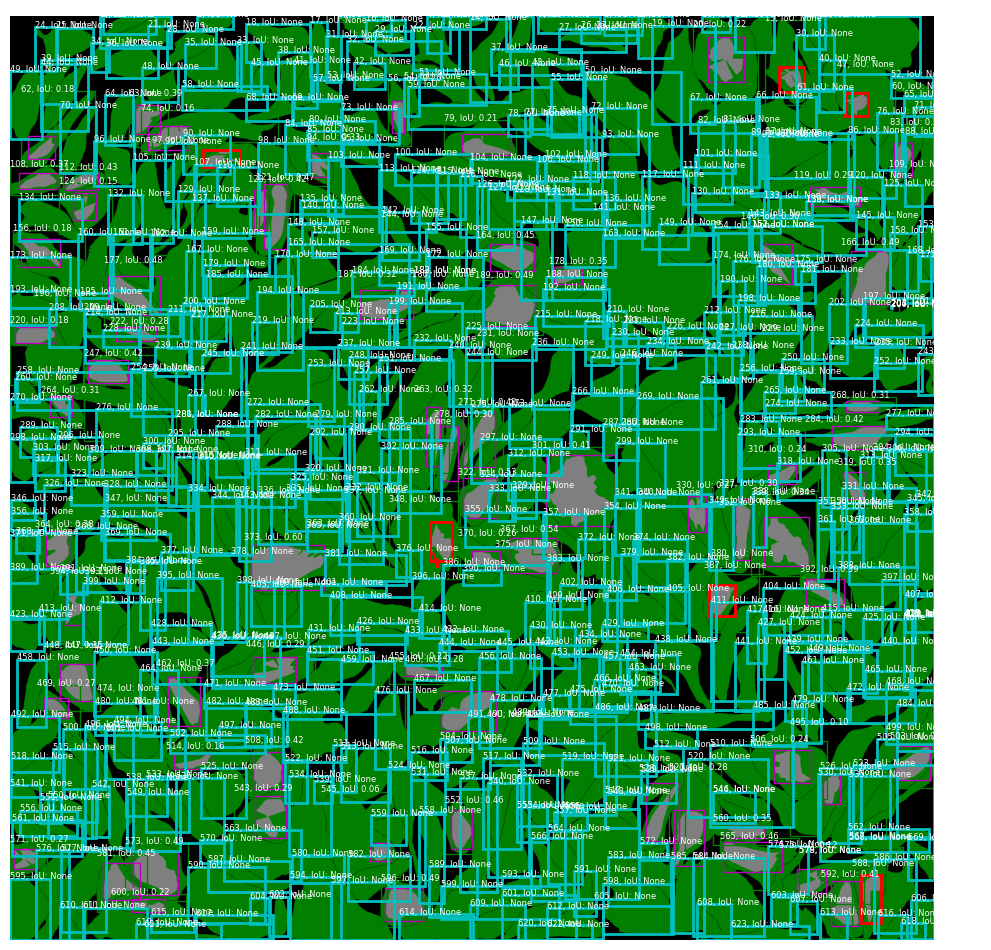

In [190]:
result.plot()